#### (5) 코드로 확인하기  

지금까지 손 계산으로 셀프 어텐션을 살펴봤는데요, 파이토치를 활용해 코드로도 확인해 보겠습니다.  
우선 입력 벡터 시퀀스 $X$와 쿼리, 키, 밸류 구축에 필요한 행렬($W_Q, W_K, W_V$) 들을 앞선 예시 그대로 정의합니다.

In [3]:
#코드 3-1 변수 정의
import torch
x = torch.tensor([
    [1.0, 0.0, 1.0, 0.0],
    [0.0, 2.0, 0.0, 2.0],
    [1.0, 1.0, 1.0, 1.0],
])
w_query = torch.tensor([
    [1.0, 0.0, 1.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 1.0, 1.0]                        
])
w_key = torch.tensor([
    [0.0, 0.0, 1.0],
    [1.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0]                  
])
w_value = torch.tensor([
    [0.0, 2.0, 1.0],
    [0.0, 3.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0]                        
])

다음 코드는 수식 3-8을 계산해 입력 벡터 시퀀스로 쿼리, 키, 밸류 벡터들을 만드는 부분입니다.  
코드에서 torch.matmul는 행렬곱을 수행하는 함수입니다.

In [9]:
#코드 3-2 쿼리, 키, 밸류 만들기
keys = torch.matmul(x, w_key)
querys = torch.matmul(x, w_query)
values = torch.matmul(x, w_value)

다음 코드는 앞 코드에서 만든 쿼리 벡터들(querys)과 키 벡터들(keys)을 행렬곱해서 어텐션 스코어를 만드는 과정입니다.  
keys.T는 키 벡터들을 전치한 행렬입니다. 

In [10]:
#코드 3-3 어텐션 스코어 만들기
attn_scores = torch.matmul(querys, key.T)

코드 3-3을 수행한 결과는 다음과 같습니다. 정확히 수식 3-17, 3-20, 3-23과 같습니다. 이들은 쿼리 벡터를 하나씩 떼어서 계산을 수행한 것인데요.  
코드 3-3처럼 쿼리 벡터들을 한꺼번에 모아서 키 벡터들과 행렬곱을 수행해도 같은 결과를 낼 수 있음을 확인할 수 있습니다.

In [11]:
attn_scores

tensor([[ 2.,  4.,  4.],
        [ 4., 16., 12.],
        [ 4., 12., 10.]])

In [12]:
#코드 3-4 소프트맥스 확률값 만들기
import numpy as np
from torch.nn.functional import softmax
key_dim_sqrt = np.sqrt(keys.shape[-1])
attn_probs = softmax(attn_scores / key_dim_sqrt, dim=-1)

이 코드를 수행한 결과는 다음과 같습니다. 정확히 수식 3-18, 3-21, 3-24와 같습니다.

In [13]:
attn_probs

tensor([[1.3613e-01, 4.3194e-01, 4.3194e-01],
        [8.9045e-04, 9.0884e-01, 9.0267e-02],
        [7.4449e-03, 7.5471e-01, 2.3785e-01]])

다음 코드는 앞 코드에서 구한 소프트맥스 확률과 밸류 벡터들을 가중합하는 과정을 수행합니다.

In [14]:
#코드 3-5 소프트맥스 확률과 밸류를 가중합하기
weighted_values = torch.matmul(attn_probs, values)

이 코드를 수행한 결과는 다음과 같습니다. 정확히 3-19, 3-22, 3-25와 같습니다.

In [15]:
weighted_values

tensor([[1.8639, 6.3194, 0.5681],
        [1.9991, 7.8141, 0.0912],
        [1.9926, 7.4796, 0.2453]])

셀프 어텐션의 학습 대상은 쿼리, 키, 밸류를 만드는 가중치 행렬($W_Q, W_K, W_V$)입니다.  
코드 예시에서는 **w_query, w_key, w_value** 입니다. 이들을 task(예를 들면 기계 번역)를 가장 잘 수행하는 방향으로 학습 과정에서 업데이트됩니다.

### 멀티 헤드 어텐션  
---
***멀티 헤드 어텐션(Mulit-Head Attention)*** 은 셀프 어텐션을 동시에 여러 번 수행하는 걸 가리킵니다. 여러 헤드가 독자적으로 셀프 어텐션을 계산한다는 이야기입니다. 비유하자면 같은 문서(입력)을 두고 독자(헤드) 여러 명이 함께 읽는 구조라 할 수 있겠습니다.

그림 3-27은 입력 단어 수는 2개, 밸류의 차원은 3개, 헤드를 8개인 멀티 헤드 어텐션을 나타낸 것입니다.  
개별 헤드의 셀프 어텐션 수행 결과는 '입력 단어 수 $\times$ 밸류 차원 수', 즉 2 $\times$ 3 크기를 갖는 행렬입니다. 8개 헤드의 셀프 어텐션 수행 결과를 다음 그림의 ①처럼 이어 붙이면 2 $\times$ 24의 행렬이 됩니다.

<center><그림 3-27 멀티 헤드 어텐션></center>

![](https://i.imgur.com/L3Qr7Nc.png)




멀티 헤드 어텐션은 개별 헤드의 셀프 어텐션 수행 결과를 이어붙인 행렬(①)에 $W^O$를 행렬곱해서 마무리됩니다. $W^O$의 크기는 '셀프 어텐션 수행 결과 행렬의 열 수 $\times$ 목표 차원 수'가 됩니다. 만일 멀티 헤드 어텐션 수행 결과($Z$)를 앞의 그림처럼 3차원으로 설정해 두고 싶다면 $W^O$는 24 $\times$ 3 크기의 행렬이 되어야 합니다.

멀티 헤드 어텐션의 최종 수행 결과는 '입력 단어 $\times$ 목표 차원 수'입니다. 앞의 그림에서는 입력 단어 2개 각각에 대해 3차원짜리 벡터가 멀티 헤드 어텐션의 최종 결과물로 도출되었습니다. 
 멀티 헤드 어텐션은 인코더, 디코더 블록 모두에 적용됩니다.  
 앞으로 특별한 언급이 없다면 셀프 어텐션은 멀티 헤드 어텐션인 것으로 이해하면 좋겠습니다.

### 인코더에서 수행하는 셀프 어텐션
---
이번엔 트랜스포머 인코더에서 수행하는 계산 과정을 셀프 어텐션 중심으로 살펴보겠습니다.  
그림 3-28은 트랜스포머 인코더 블록을 나타낸 것인데요, 기억을 떠올리고자 다시 가져왔습니다. 인코더 블록의 입력은 이전 블록의 단어 벡터 시퀀스(그림에서 붉은색 실선), 출력은 이번 블록 수행 결과로 도출된 단어 벡터 시퀀스(그림에서 녹색 실선)입니다.

<center><그림 3-28 트랜스포머 인코더 블록></center>

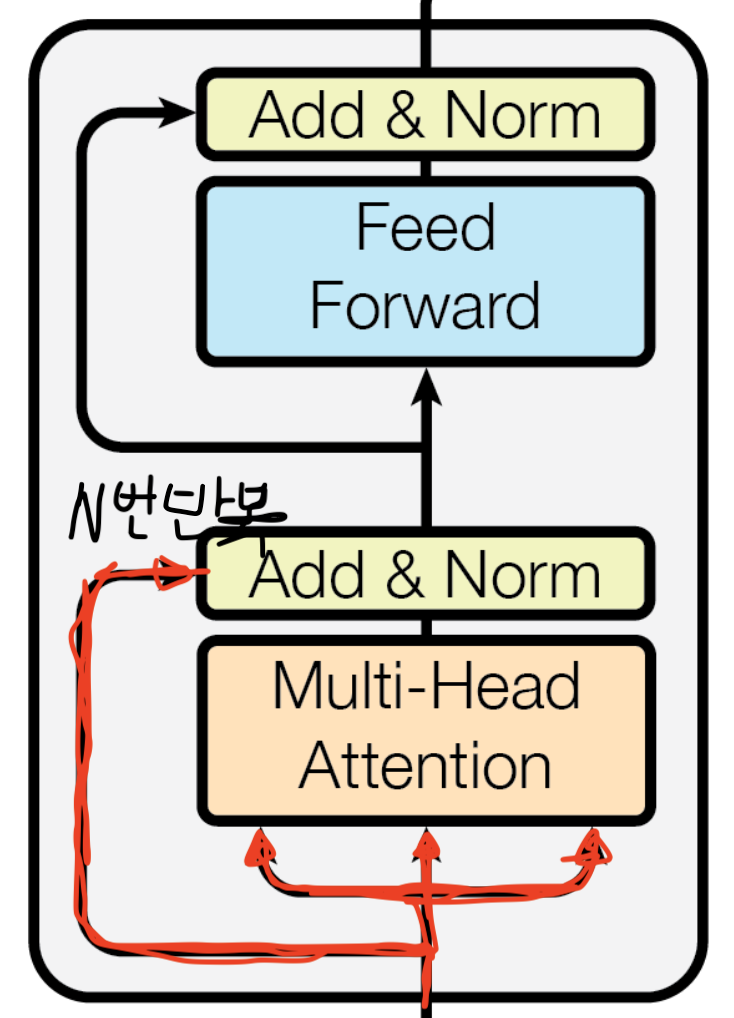

인코더에서 수행되는 셀프 어텐션은 쿼리, 키, 밸류가 모두 소스 시퀀스와 관련된 정보입니다. 트랜스포머의 학습 과제가 한국어에서 영어로 번역하는 task라면 인코더의 쿼리, 키, 밸류는 모두 한국어가 된다는 이야기입니다.

다음 그림은 쿼리가 **어제**일 때 셀프 어텐션을 나타냈습니다. 잘 학습된 트랜스포머라면 쿼리, 키로부터 계산한 소프트맥스 확률(코드 3-5의 **attn_probs**에 대응) 가운데 과거 시제에 해당하는 **갔었어, 많더라** 등의 단어가 높은 값을 지닐 겁니다. 이 확률과 밸류 벡터를 가중합해서 셀프 어텐션 계산을 마칩니다.

<center><그림 3-29 쿼리가 '어제'일 때 셀프 어텐션></center>


![](https://i.imgur.com/ydO8rUt.jpg)

다음 그림은 쿼리가 **카페**일 때 셀프 어텐션을 나타냈습니다. 잘 학습된 트랜스포머라면 쿼리, 키로부터 계산한 소프트맥스 확률 가운데 장소를 지칭하는 대명사 **거기**가 높은 값을 지닐 겁니다. 이 확률과 밸류 벡터를 가중합해서 셀프 어텐션 계산을 마칩니다.

<center><그림 3-30 쿼리가 '카페'일 때 셀프 어텐션></center>

![](https://i.imgur.com/QgIcjoJ.jpg)

이러한 계산을 **갔었어, 거기, 사람, 많더라**를 대상으로도 수행합니다. 결국 인코더에서 수행하는 셀프 어텐션은 소스 시퀀스 내의 모든 단어 쌍(pair) 사이의 관계를 고려하게 됩니다.